In [1]:
import pandas as pd
import numpy as np
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple
from sklearn.metrics import confusion_matrix

import os
import random
from collections import OrderedDict
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'


if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device("mps")

print(device)

mps


In [2]:
# Train data
train = pd.read_csv('train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["image1"].apply(lambda x: f"sign_data/full/{x}")
train["image_forged_paths"] = train["image2"].apply(lambda x: f"sign_data/full/{x}")

# Test data
test = pd.read_csv('test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["image1"].apply(lambda x: f"sign_data/full/{x}")
test["image_forged_paths"] = test["image2"].apply(lambda x: f"sign_data/full/{x}")

In [3]:
train["label"].value_counts(normalize=True)

label
1    0.54304
0    0.45696
Name: proportion, dtype: float64

In [4]:
test["label"].value_counts(normalize=True)

label
1    0.543085
0    0.456915
Name: proportion, dtype: float64

In [5]:
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score

def seed_torch(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(42)

In [6]:
def preprocess_signature(img: np.ndarray, canvas_size: Tuple[int, int], img_size: Tuple[int, int] =(170, 242), input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped

In [7]:
def normalize_image(img: np.ndarray, canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)
    threshold = filters.threshold_otsu(img)

    # Find CoM
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    cropped = img[r.min(): r.max(), c.min(): c.max()]
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    if img_rows > max_rows:
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped
    normalized_image[normalized_image > threshold] = 255

    return normalized_image

In [8]:
def remove_background(img: np.ndarray) -> np.ndarray:
    
        img = img.astype(np.uint8)
        threshold = filters.threshold_otsu(img)
        img[img > threshold] = 255
        return img

In [9]:
def resize_image(img: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
    height, width = size
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]

In [10]:
def crop_center(img: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def crop_center_multiple(imgs: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

In [11]:
def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [12]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train.iloc[5]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

In [13]:
class SignatureDataset(Dataset):
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]  
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)  
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return torch.tensor(img1), torch.tensor(img2), label.float()

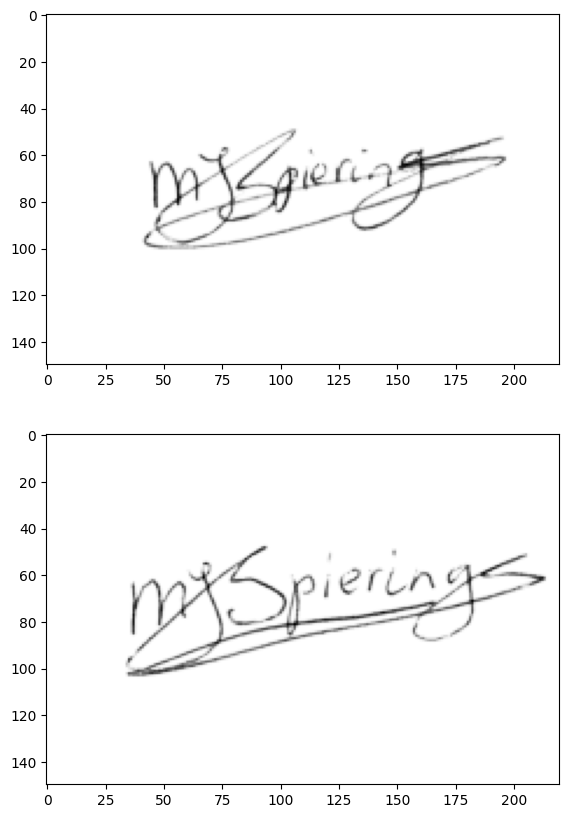

In [14]:
train_dataset = SignatureDataset(train, canvas_size, input_size)
img1, img2, _ = train_dataset[1]
f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [29]:
class SigNet(nn.Module):
    def __init__(self):
        super(SigNet, self).__init__()
        self.feature_space_size = 2048
        self.conv_layers = nn.Sequential(
            nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(1, 96, 11, stride=4, padding=0, bias=False)),
                ('bn', nn.BatchNorm2d(96)),
                ('mish', nn.Mish())
            ])), 
            nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(96, 256, 5, stride=1, padding=2, bias=False)),
                ('bn', nn.BatchNorm2d(256)),
                ('mish', nn.Mish())
            ])),
            nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(256, 384, 3, stride=1, padding=1, bias=False)),
                ('bn', nn.BatchNorm2d(384)),
                ('mish', nn.Mish())
            ])), 
            nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(384, 384, 3, stride=1, padding=1, bias=False)),
                ('bn', nn.BatchNorm2d(384)),
                ('mish', nn.Mish())
            ])),
            nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(384, 256, 3, stride=1, padding=1, bias=False)),
                ('bn', nn.BatchNorm2d(256)),
                ('mish', nn.Mish())
            ]))
        )
        self.fc_layers = nn.Sequential(
            nn.Sequential(OrderedDict([
                ('fc', nn.Linear(256 * 3 * 5, 2048, bias=False)),
                ('bn', nn.BatchNorm1d(2048)),
                ('mish', nn.Mish())
            ])),
            nn.Sequential(OrderedDict([
                ('fc', nn.Linear(2048, 2048, bias=False)),
                ('bn', nn.BatchNorm1d(2048)),
                ('mish', nn.Mish())
            ]))
        )

    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        img1 = img1.view(-1, 1, 150, 220).float() / 255.0
        img2 = img2.view(-1, 1, 150, 220).float() / 255.0
        output1 = self.forward_once(img1)
        output2 = self.forward_once(img2)
        return output1, output2

class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        self.prob_layer = nn.Linear(4, 1)
        self.projection_layer = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        return self.model.forward_once(img)
        
    def forward(self, img1, img2):
        img1 = img1.view(-1, 1, 150, 220).float() / 255.0
        img2 = img2.view(-1, 1, 150, 220).float() / 255.0
        
        embedding1 = self.forward_once(img1)
        embedding2 = self.forward_once(img2)
        
        embedding1 = self.projection_layer(embedding1)
        embedding2 = self.projection_layer(embedding2)
        
        combined_output = torch.cat([embedding1, embedding2], dim=1)
        similarity_score = self.prob_layer(combined_output)
        
        return embedding1, embedding2, similarity_score

In [ ]:
# # Load the state dictionary
# state_dict, _, _ = torch.load("single_model.pth")
# 
# # Print the keys
# print("Keys in the state dictionary:")
# for key in state_dict.keys():
#     print(key)

In [22]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def train_function(train_loader, model, criterions, optimizer, epoch, scheduler, device):
    losses = AverageMeter()
    model.train()
    
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2
        
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
        
        if (step + 1) % 1 == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            
        if step % 100 == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: 1e-3')
    return losses.avg

In [ ]:
seed_torch(42)

train_dataset = SignatureDataset(train, (952, 1360), (256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=32, 
                              shuffle=True)

def get_scheduler(optimizer):
    scheduler = CosineAnnealingLR(optimizer, **{
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    })
    return scheduler

model = SiameseModel()
model.to(device)

In [21]:
# optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
# try:
#     scheduler = get_scheduler(optimizer)
# except:
#     print('Learning scheduler is not used')
# 
# contrastive = ContrastiveLoss() # Contrastive loss
# binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
# best_score = 0.
# best_loss = np.inf
# 
# for epoch in range(20):
#     avg_loss = train_function(train, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)
#     scheduler.step()
#     
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         torch.save({'model': model.state_dict()}, 'best_model_21.pt')

In [ ]:
seed_torch(42)
model = SiameseModel()
model.load_state_dict(torch.load('best_model_21.pt')['model'])


test_dataset = SignatureDataset(test, (952, 1360), (256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1, 
                              shuffle=True)

counter = 0 
label_dict = {0.0:'Forged', 1.0:'Genuine'}
model.eval()

Confusion Matrix:
 [[396 137]
 [281 187]]


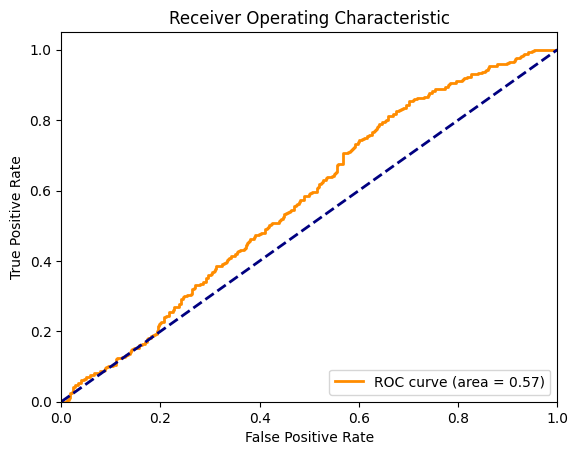

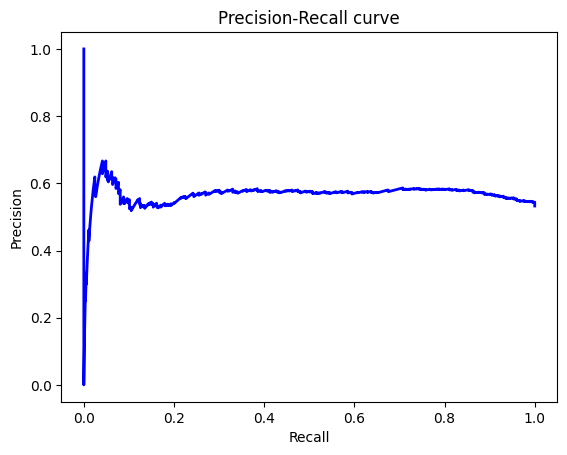

In [46]:
true_labels = []
predicted_labels = []
confidence_scores = []

for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu').item()
    # Consider as 'genuine' if confidence > 0.6
    predicted = 1 if confidence > 0.49 else 0
    true_labels.append(label.item())
    predicted_labels.append(predicted)
    confidence_scores.append(confidence)
    if i==1000:
        break

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[1, 0])
print("Confusion Matrix:\n", conf_matrix)

# Plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, confidence_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.svg', format='svg')
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(true_labels, confidence_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.savefig('precision_recall_curve.svg', format='svg')
plt.show()

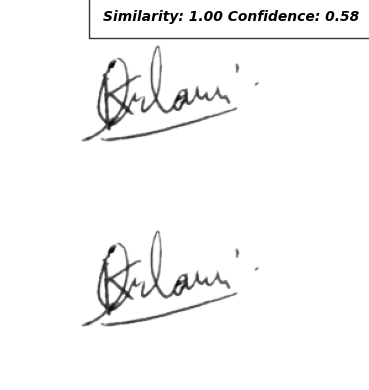

In [41]:
def fetch_img(real_file_path, forged_file_path):
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, (952, 1360), (256, 256))
        img2 = preprocess_signature(img2, (952, 1360), (256, 256))
        
        return torch.tensor(img1), torch.tensor(img2)

img1_tensor, img2_tensor = fetch_img("signatures/kg1.jpg", "signatures/kg1.jpg")
#img1_tensor, img2_tensor = fetch_img("../signatures/hb1.png", "../signatures/hb1.png")

# Load model and set to evaluation mode
model.eval()
model.to('cpu')  # Ensure model is on the correct device

# Inference
with torch.no_grad():
    op1, op2, confidence = model(img1_tensor, img2_tensor)
    confidence = torch.sigmoid(confidence).item()  # Convert output to probability
    cos_sim = F.cosine_similarity(op1, op2).item()  # Calculate cosine similarity

# Visualization of results
concatenated = torch.cat((img1_tensor, img2_tensor), 0)
imshow(torchvision.utils.make_grid(concatenated), f'Similarity: {cos_sim:.2f} Confidence: {confidence:.2f}')


## 